# N-gram Lanuage Models

Our goal is to build a machine that assigns probabilities to words or sequences of words. We call such machine *language model*. 

The probability model is over the set of all finite sequences over a given vocabulary (aka alphabet) $\mathcal W$, which is countable. 



A simple class of language models are N-gram model, in which we make the assumption:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i | w_{i-N+1},\ldots,w_{i-1}] = \prod_{i=1}^n \Pr[w_i | w^{i-1}_{i-N+1}] 
$$
where:
$$ 
w^{m+p}_{m} := \begin{cases} (w_m,\ldots,w_{m+p}) & m \geq 1, \\
\emptyset & m=0,
\end{cases}
$$
for $m,p \in \mathbb N$. 


For example, with $N=2$ we have:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] =  \Pr[w_1]\prod_{i=2}^n \Pr[w_i | w_{i-1}] 
$$


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

## Building N-gram models

### Large Movie Review Dataset

Link to download class version: https://cloud.cs.idc.ac.il/index.php/s/ScL9qfw3zTHy8x8

Original dataset is from https://ai.stanford.edu/~amaas/data/sentiment/: This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

(direct link https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

Here we use this dataset arranged in a .csv file as an be found at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download


Read dataset file. Each row is a review. 

In [2]:
df = pd.read_csv("/Users/kipnisal/Data/IMDB reviews.csv")
print(df.describe())
print(df.head())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


####  Add sentence start and end symbols:

In [3]:
import re

SENT_START_TOKEN = '<s>'
SENT_END_TOKEN = '</s>'

def split_to_sentences(text: str, sep=r'\.|\n') -> str:
    """
    Add SENT_START_TOKEN and SENT_END_TOKEN at the beginning and
    ending of every sentence. 
    
    Args:
        :text: is a text input
        :sep: explains how to identify sentnce ending (regular expression)
    """
    return re.split(sep, text)

def add_sentence_break_symbols(sentences: list) -> str:
    sent_break = f' {SENT_END_TOKEN} {SENT_START_TOKEN} '
    return SENT_START_TOKEN + ' ' + sent_break.join(sentences) + ' ' + SENT_END_TOKEN

df['review_sb'] = df['review'].apply(split_to_sentences).apply(add_sentence_break_symbols)

In [4]:
print(df.head())

                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                           review_sb  
0  <s> One of the other reviewers has mentioned t...  
1  <s> A wonderful little production </s> <s>  <b...  
2  <s> I thought this was a wonderful way to spen...  
3  <s> Basically there's a family where a little ...  
4  <s> Petter Mattei's "Love in the Time of Money...  


### Unigram Model:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i] 
$$
(assign probability to sentences based on frequency of occurances of words regardless of neighboring words or their location in the sentence).


We first list all words. We ignore capitalization, numbers, punctuations and white spaces. We use this 'cleaning' process for simplicity, but it is not always a good idea and we may not do the same for more sophisticated models.

In [5]:
TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"

tokens = []
for sent in tqdm(df['review_sb']):
    tokens += re.findall(TOKEN_PATTERN, sent.lower())

100%|██████████| 50000/50000 [00:02<00:00, 23366.22it/s]


(you can get yourself familiar with regular expressions at https://www.regular-expressions.info/)

The next line actualy does the counting; it uses ``value_counts`` method of ``pandas``

In [17]:
df_counts = pd.DataFrame(pd.DataFrame(tokens).value_counts())\
                .rename(columns = {0 : 'count'})

df_counts.loc[:, 'freq'] = df_counts['count'] / df_counts['count'].sum()
model_1gram = df_counts

In [14]:
model_1gram.head(10)

,count,freq
0,,
</s>,700520,0.052692
<s>,700520,0.052692
the,667993,0.050246
and,324441,0.024404
a,322970,0.024294
of,289410,0.021769
to,268124,0.020168
is,211082,0.015877
br,201951,0.015191


We see that the two special symbols are also most frequent. These symbols are not informative in a unigram model hence we remove them:

In [18]:
model_1gram = model_1gram.drop(['</s>', '<s>'])   # remove symbols
model_1gram['freq'] = model_1gram['count'] / model_1gram['count'].sum()  # re-calculate frequencies

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65861/1433239876.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  model_1gram = model_1gram.drop(['</s>', '<s>'])   # remove symbols


In [19]:
model_1gram.head(15)

,count,freq
0,,
the,667993,0.056165
and,324441,0.027279
a,322970,0.027155
of,289410,0.024334
to,268124,0.022544
is,211082,0.017748
br,201951,0.016980
it,190857,0.016047
in,186781,0.015705


Illustrating "Zipf law" $f_i \propto 1/i$ for uniframs. Zipf "law" is a phenomena discovered by American linguist George Kingsley Zipf
https://en.wikipedia.org/wiki/George_Kingsley_Zipf

The Zipf phenomena only occurs in the most frequent words, after which the tail become thiner than $1/i$ (converges to zero faster) 

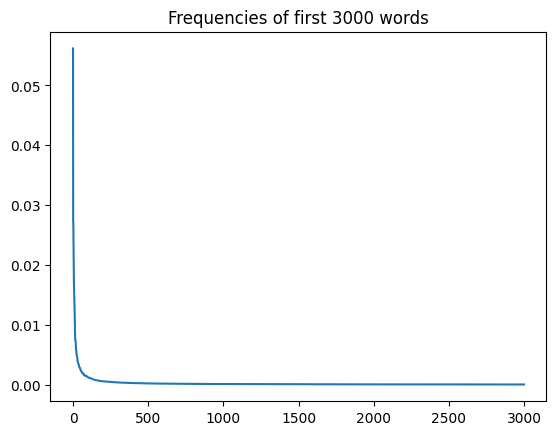

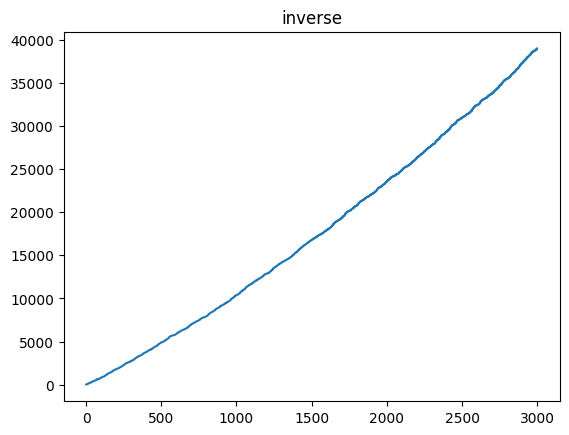

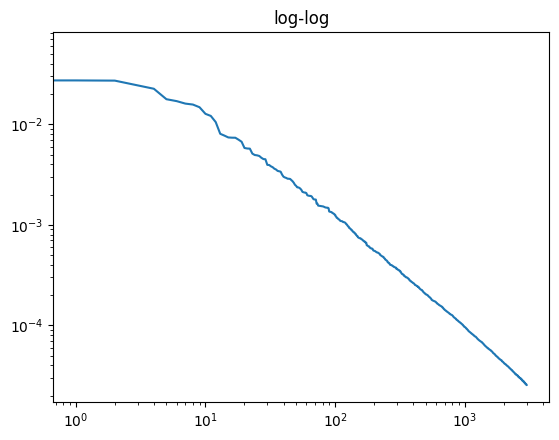

In [31]:
n = 3000
plt.title(f"Frequencies of first {n} words")
plt.plot(model_1gram.freq.values[:n])
plt.show()

plt.title("inverse")
plt.plot(1 / model_1gram.freq.values[:n])
plt.show()

plt.title("log-log")
plt.loglog(model_1gram.freq.values[:n])
plt.show()

The entire procedure is summarized as follows

In [21]:
from nltk import ngrams
TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"
SENT_START_TOKEN = '<s>'
SENT_END_TOKEN = '</s>'


def is_sublist(list_a: list, list_b: list)-> bool:
    """
    Is list_a a sublist of list_b?
    """
    return str(list_a).strip('[').strip(']') in str(list_b)


def ng_tokenize(text: str, ng: int) -> list:
    """
    extract ngram and add sepcial symbols
    
    Args:
      :text:  text
      :ng:    ngram level
      
    Returns:
      list of ngrams 
    """
    tokens = re.findall(TOKEN_PATTERN, text.lower())
    ngz = ngrams(tokens, ng,
                 pad_left=True, pad_right=True,
                 left_pad_symbol=SENT_START_TOKEN,
                 right_pad_symbol=SENT_END_TOKEN)
    return list(ngz)


def clean_text(text: str) -> str:
    """
    clean text 
    """    
    text = text.lower()
    text = re.sub(r"<br ?/>", " ", text)  # replace '<br />' with ' '
    text = re.sub(r"\.\.+", " ", text)  # replace '..' or a longer sequence with ' '
    
    return text


def build_ngram_model(text: str, ng: int) -> pd.DataFrame:
    """
    1. Clean text
    2. Add sentence begin and end symbols
    3. Extract ngrams
    4. Remove unwanted tokens
    5. Compute frequency of every token
    
    Returns:
      dataframe. Indexes are ngrams. Columns indiacte number of occurances 
      and frequency of occurance
    """
    print("Cleaning text...")
    text = clean_text(text)
    print("Breaking to sentences")
    sentences = split_to_sentences(text)
    print("Extracting tokens...")
    tokens = []
    for sent in tqdm(sentences):
        tokens += ng_tokenize(sent, ng)
    print("Removing unacceptable tokens...")
    tokens = [t for t in tokens if not 
              (('<s>' in t[1:]) or ('</s>' in t[:-1]) or (is_sublist(["<s>", "</s>"], t)))]
    print("Counting tokens...")
    df_ng = pd.DataFrame(pd.DataFrame(tokens).value_counts()).rename(columns = {0 : 'count'})
    print("Computing frequencies...")
    df_ng.loc[:, 'freq'] = df_ng['count'] / df_ng['count'].sum()  # compute frequencies
    return df_ng

### Bigram Model:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i|w_{i-1}] 
$$
(assign probability to sentences based on frequency of occurances of a word given the previous word in the sentence).


In [22]:
model_2gram = build_ngram_model(" ".join(df.review), 2)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 564901/564901 [00:03<00:00, 163767.47it/s]


Removing unacceptible tokens...
Counting tokens...
Computing frequencies...


In [24]:
k = 15
print(f" {k} most frequenct bigrams:")
model_2gram

 15 most frequenct bigrams:


count          freq
0                                            1                           
of                                           the      77275  6.306123e-03
<s>                                          the      70588  5.760422e-03
                                             i        55533  4.531840e-03
in                                           the      50275  4.102754e-03
it                                           s        33762  2.755190e-03
...                                                     ...           ...
help                                         kill         1  8.160625e-08
                                             kidman       1  8.160625e-08
                                             kidd         1  8.160625e-08
                                             keitaro      1  8.160625e-08
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz </s>         1  8.160625e-08

[2117313 rows x 2 columns]

Bigrams also obey the Zipf law:

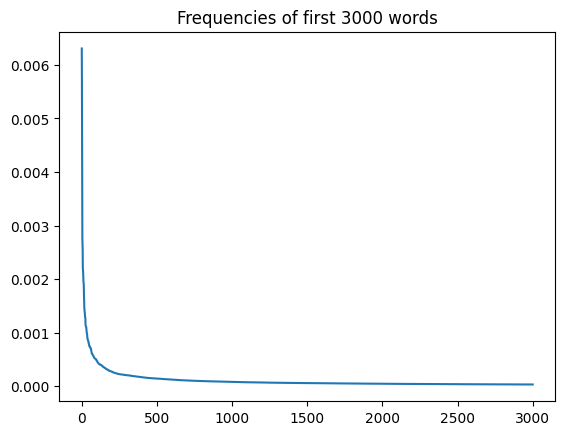

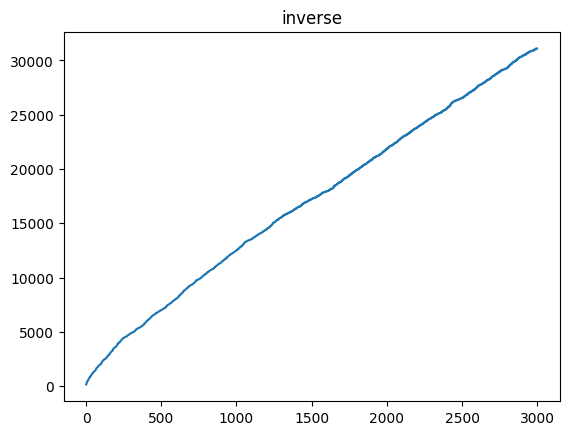

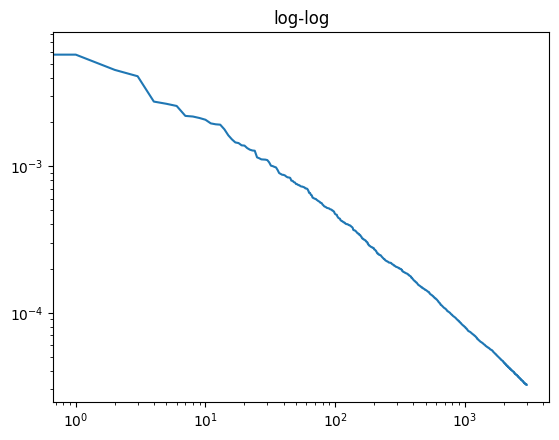

In [30]:
n = 3000

plt.title(f"Frequencies of first {n} words")
plt.plot(model_2gram.freq.values[:n])
plt.show()

plt.title("inverse")
plt.plot(1 / model_2gram.freq.values[:n])
plt.show()

plt.title("log-log")
plt.loglog(model_2gram.freq.values[:n])
plt.show()

### Trigram Model

$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i|w_{i-1},w_{i-2}] 
$$


In [32]:
model_3gram = build_ngram_model(" ".join(df.review), ng=3)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 564901/564901 [00:03<00:00, 144163.41it/s]


Removing unacceptible tokens...
Counting tokens...
Computing frequencies...


In [33]:
k = 15
print(f"{k} most frequent 3grams:")
print(model_3gram.head(k))

15 most frequent 3grams:
                  count      freq
0    1     2                     
<s>  it    s      10596  0.000906
one  of    the     9824  0.000840
<s>  this  is      7837  0.000670
     it    is      5728  0.000490
     if    you     5523  0.000472
i    don   t       5421  0.000464
this movie is      5277  0.000451
of   the   film    5173  0.000442
<s>  this  movie   5120  0.000438
this is    a       4817  0.000412
it   s     a       4703  0.000402
a    lot   of      4694  0.000401
of   the   movie   4330  0.000370
<s>  the   film    4227  0.000362
this movie </s>    4114  0.000352


# Sentence probability


In [34]:
class State(object):
    """
    class to manage sequential state progression
    
    Args:
        past, present, future are lists
        
    Methods:
        State::step   update one step in time, so that the present 
        is appended to the past and the present gets the next value from the future
    """
    def __init__(self, past: list, present: list, future: list):
        self.past = past
        self.present = present
        self.future = future
        
    def step(self):
        self.past += self.present
        if len(self.future) > 0:
            self.present = [self.future.pop(0)]
        else:
            self.present = []
            self.future = []
            
    def print_state(self):
        print("past:", self.past)
        print("present:", self.present)
        print("future:", self.future)


In [36]:

def token_probability(token : str, model: pd.DataFrame) -> float:
    """
    probability of a token under the model
    
    Notes: 
    1. Returns the marginal probability if the token is smaller than the size of the model
    2. Returns 1 if token == "" or token == [].
    """
    
    
    if len(token) == 0:  
        return 1     # we agree that an empty token has probability 1
    token_idx = tuple(token)
    
    if token_idx in model.index:
        return model.loc[token_idx].freq.sum()  # the sum is to allow marginalization if
                                                # the token is smaller than an n-gram
    # else:
    print(f"Unrecognized Token '{token}'")
    raise ValueError                
    

def conditional_probability(token_a: list, token_b: list, model: pd.DataFrame, verbose=False) -> float:
    """
    Probability of token_a given token_b under the model
    (token can contain multiple words depending on the model definition)
    """
    
    pr_b = token_probability(token_b, model)
    pr_ab = token_probability(token_b + token_a, model)
    return pr_ab / pr_b
    
    
def sentence_probability(sent: str, model: pd.DataFrame,
                         verbose=False, backoff=False) -> float:
    """
    Probability of a sentence under an n-gram languge model
    
    Args:
        :sent:    the sentence 
        :model:   the model
        :verbose: flag whther to print computing process
        :bakcoff: try backing off to handle unknown ngrams
        
    Returns:
       probability
    """
    
    ng = len(model.index[0])  # identify model order

    sent_atoms = sent.split()  
    first_token = sent_atoms[:1] 

    word_stream = State(past=[], present=first_token, future=sent_atoms[1:])

    # update state
    logprob = 0
    while len(word_stream.present) > 0:
        if backoff:
            pr_token = conditional_probability_backoff(word_stream.present,
                                                       word_stream.past[-ng+1:],
                                                       model, verbose=verbose)
        else:
            pr_token = conditional_probability(word_stream.present, word_stream.past[-ng+1:],
                                               model)
        logprob += np.log(pr_token)
        if verbose:
            word_stream.print_state()
            print(f"P(present|past) = {pr_token}")
            print("------------------------------------")
        word_stream.step()

    return np.exp(logprob)


def conditional_probability_backoff(token_a:str, token_b:str, model: pd.DataFrame, verbose=False) -> float:
    """
    same as `conditional_probability`, but backs off if n-gram token_a + token_b 
    is not recognized by the model. 
    
     """
    
    joint_token_idx = tuple(token_b + token_a)
        
    if (joint_token_idx not in model.index) and (token_b != []):
        if verbose:
            print(f"Token_a = {token_a}, Backing-off from {token_b} to {token_b[1:]}...")
        
        return conditional_probability_backoff(token_a, token_b[1:], model)
    
    return conditional_probability(token_a, token_b, model)
   
    


Make sure that conditional probability behaves as expected:

In [46]:
import warnings

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

test_tokens = ['<s>', 'on', 'of', 'there', 'movie']
for t in test_tokens:
    assert conditional_probability([t],[], model_2gram) == token_probability([t], model_2gram)

### Probability of a bigram:

In [54]:
print(conditional_probability(['of'], ['one'], model_2gram)) #* token_probability('one', model_2gram))
print()
print(sentence_probability("one of", model_2gram))
print(sentence_probability("<s> one of", model_2gram))
print(sentence_probability("<s> one of </s>", model_2gram))
print(sentence_probability("one of </s>", model_2gram))

0.303154674178684

0.0013261014966259083
9.250029841397449e-05
5.506997483406865e-07
7.894934102783051e-06


In [64]:
print(sentence_probability("<s> one of the", model_2gram))
print(sentence_probability("<s> one of the best", model_2gram))
print(sentence_probability("<s> one of the best performance", model_2gram))

2.4698388307038047e-05
2.6029711940326926e-07
4.643740236737678e-09


Discuss the differences

#### Probability of a longer sentence:

##### Bigram model:
As opposed to what was said in class, the probability calculation below of the first two token is correct. The part that is incorrect or meaningless is the printout: P(present|past) in the first token. Indeed, one can verify that as follows:

In [67]:
print(sentence_probability("<s> one of", model_2gram, verbose=True))

past: []
present: ['<s>']
future: ['one', 'of']
P(present|past) = 0.04590016748865917
------------------------------------
past: ['<s>']
present: ['one']
future: ['of']
P(present|past) = 0.006647595646971604
------------------------------------
past: ['<s>', 'one']
present: ['of']
future: []
P(present|past) = 0.303154674178684
------------------------------------
9.250029841397449e-05


In [70]:
print("<s> one ", token_probability(["<s>", "one"], model_2gram))
print("one of  ", token_probability(["one", "of"], model_2gram))

<s> one  0.0003051257535928782
one of   0.0013261014966259083


In [74]:
print(sentence_probability("<s> no one expects the star trek movies to be high art </s>", model_2gram, verbose=True))

past: []
present: ['<s>']
future: ['no', 'one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.04590016748865917
------------------------------------
past: ['<s>']
present: ['no']
future: ['one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.0040554067051998465
------------------------------------
past: ['<s>', 'no']
present: ['one']
future: ['expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.07081290526648742
------------------------------------
past: ['<s>', 'no', 'one']
present: ['expects']
future: ['the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.000596981512228793
------------------------------------
past: ['<s>', 'no', 'one', 'expects']
present: ['the']
future: ['star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.14843749999999997
--------------------------------

##### Trigram model

In [75]:
sentence_probability("<s> what", model_3gram, verbose=True)

past: []
present: ['<s>']
future: ['what']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['what']
future: []
P(present|past) = 0.008789974024773356
------------------------------------


0.0004228711359230482

In [76]:
token_probability(['<s>', 'what'], model_3gram)

0.0004228711359230483

In [77]:
print(sentence_probability("<s> no one expects the star trek movies to be high art </s>", model_3gram, verbose=True))

past: []
present: ['<s>']
future: ['no', 'one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['no']
future: ['one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.004055406705199845
------------------------------------
past: ['<s>', 'no']
present: ['one']
future: ['expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.1297676457693994
------------------------------------
past: ['<s>', 'no', 'one']
present: ['expects']
future: ['the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.0033500837520938015
------------------------------------
past: ['<s>', 'no', 'one', 'expects']
present: ['the']
future: ['star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.15624999999999994
---------------------------------

Trigram probability is generally higher for "natural" sentences

In [112]:
print(sentence_probability("<s> one expects the star trek movies to be okay", model_3gram))

7.954344078841356e-18


In [109]:
print(sentence_probability("<s> one expects the star trek movies to be fair", model_3gram))

2.883449728580011e-16


In [89]:
sent = "<s> a wonderful little production </s>"
print(f"2gram probability of '{sent}': p = ", sentence_probability(sent, model_2gram))
print(f"3gram probability of '{sent}': p = ", sentence_probability(sent, model_3gram))

2gram probability of '<s> a wonderful little production </s>': p =  7.83138402611925e-13
3gram probability of '<s> a wonderful little production </s>': p =  6.345117780912522e-10


In general, the 3-gram model gives higher probabilities to more English looking sentences

### What kinds of knowledge we can get from a model?

In [114]:
model = model_3gram
print("actor vs. actress")
print("=================")

for w in ['good', 'great', 'talented', 'poor']:
    print(w)
    p1 = conditional_probability(['actor'], [w.lower()], model)
    p2 = conditional_probability(['actress'], [w.lower()], model)
    print("\t","actor: ", p1)
    print("\t","actress: ", p2)
    print("\t","actor/actress ratio: ", p1 / p2)


actor vs. actress
good
	 actor:  0.006738692547152538
	 actress:  0.003296099615455045
	 actor/actress ratio:  2.044444444444445
great
	 actor:  0.011464819880114068
	 actress:  0.004655764418320434
	 actor/actress ratio:  2.4625
talented
	 actor:  0.04549590536851683
	 actress:  0.03366696997270246
	 actor/actress ratio:  1.3513513513513513
poor
	 actor:  0.001943904470980283
	 actress:  0.0005554012774229379
	 actor/actress ratio:  3.500000000000001


Gramer correction:

In [121]:
model = model_3gram
print(sentence_probability("one of the best action movies </s>", model))
print(sentence_probability("one of the best action movie </s>", model))

3.7215893357787573e-09
2.1854113201173367e-09


In [125]:
model = model_2gram
print(sentence_probability("talking at her", model))
print(sentence_probability("talking with her", model))
print(sentence_probability("talking to her", model))

5.7194121090505905e-09
6.281872613389775e-08
1.1115748059008867e-07


Movies are more likely to be watched than read:

In [126]:
print(sentence_probability("<s> only one movie to read </s>", model_3gram))
print(sentence_probability("<s> only one movie to watch </s>", model_3gram))

5.005703106712864e-15
5.081338926216576e-12


### The method breaks when we ask for unseen ngrams:

In [127]:
print(sentence_probability("<s> a great movie to bake at home </s>", model_3gram))

Unrecognized Token '['movie', 'to', 'bake']'


ValueError: 

One solution is "simple backoff":
$$
\Pr[w_i|w_{i-N+1}^{i-1}] \approx \Pr[w_i|w_{i-k+2}^{i-1}]
$$
(removing words from the tail of the conditioned sentence)

In [128]:
print(sentence_probability("<s> a great movie to bake at home </s>", model_3gram, backoff=True, verbose=True))

past: []
present: ['<s>']
future: ['a', 'great', 'movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['a']
future: ['great', 'movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.01580559649681132
------------------------------------
past: ['<s>', 'a']
present: ['great']
future: ['movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.025084364454443193
------------------------------------
past: ['<s>', 'a', 'great']
present: ['movie']
future: ['to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.09749626927541037
------------------------------------
past: ['<s>', 'a', 'great', 'movie']
present: ['to']
future: ['bake', 'at', 'home', '</s>']
P(present|past) = 0.0599250936329588
------------------------------------
Token_a = ['bake'], Backing-off from ['movie', 'to'] to ['to']...
past: ['<s>', 'a', 'great', 'movie', 'to']
present: ['bake']
future: ['at', 'home', '</s>']
P(pre

Note that with "simple backoff" we no longer have a probability distribution interpertation. 

Other techniques to handle zeros: See [Jurafsky & Martin] for details. 

## logloss/Logloss/Empirical Entropy

### Log logloss of sequence $w^n=(w_1,\ldots,w_n)$ under model P:
$$
logloss(w^n,P) = - \frac{1}{n} \log(\Pr[w^n]) = - \frac{1}{n} \sum_{i=1}^n \log(\Pr[w_i|w^{i-1}_{i-N+1}]) 
$$

In [129]:
def logloss(sentence: str, model: pd.DataFrame) -> float:
    """
    evalaute the logloss of `sentence` under the model
    """
    N = len(sentence.split())
    prob = sentence_probability(sentence, model, backoff=True)
    return -np.log(prob) / N
        

Logloss of a single sentence:

In [130]:
sentences = ["<s> not as good as your average movie but still does the trick </s>",
             "<s> great do me but soon get out </s>"]

for sent in sentences:
    print("Sentence: ", sent)
    print(f"Logloss of bigram model = {logloss(sent, model_2gram)}")
    print(f"Logloss of trigram model = {logloss(sent, model_3gram)}")
    print()

Sentence:  <s> not as good as your average movie but still does the trick </s>
Logloss of bigram model = 4.60081664621313
Logloss of trigram model = 3.645750498744358

Sentence:  <s> great do me but soon get out </s>
Logloss of bigram model = 5.580155663436397
Logloss of trigram model = 5.353465224792829



Logloss of many sentences

In [131]:
import re


def preprocess_sentence(text: str) -> str:
    """
    clean text according to tokenizer and  
    add sybols indicating beginning and ending
    """
    return  '<s> ' + " ".join(re.findall(TOKEN_PATTERN, text)).lower() + ' </s>'


def to_sentences(text: str) -> list:
    """
    Convert text after preprocessing to a list 
    of sentences
    """
    text = clean_text(text)
    sentences = split_to_sentences(text)
    return [preprocess_sentence(sent) for sent in sentences if len(sent.split()) > 2]



In [132]:
model = model_2gram

N = 100
test_set = df.sample(N).review.apply(clean_text)

ls = []
for doc in tqdm(test_set):
    for sent in to_sentences(doc):
        try:
            ll = logloss(sent, model)
            if ll > 0:
                ls += [ll]
        except:
            print("Cound not evaluate logloss of sent: ", sent)
print(f"Average logloss of bigram model over {N} samples: {np.mean(ls)}, (std = {np.std(ls)})")


 86%|████████▌ | 86/100 [03:27<00:42,  3.01s/it]

Unrecognized Token '['</s>']'
Cound not evaluate logloss of sent:  <s> dr jacques coulardeau university paris dauphine university paris pantheon sorbonne university versailles saint quentin en yvelines </s>


100%|██████████| 100/100 [04:08<00:00,  2.49s/it]

Average LPP of bigram model over 100 samples: 4.6892438508442025, (std = 0.5122211742369691)


## Sampling from the model
generate random sentences according to model's probability

In [133]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def sample_from_model(ngram_model, prompt=['<s>']):
    
    def sample_from_list(df):
        return df.sample(n=1, weights = df.freq)
    
    w = ''
    state = prompt
    smp = sample_from_list(ngram_model.loc[state])
    state = list(smp.index[0][1:])
    w = list(state)
    while w[-1] != '</s>': 
        df_pool = ngram_model.loc[tuple(state)]
        smp = df_pool.sample(n=1, weights = df_pool.freq)
        state = state[1:] + [smp.index[0]]
        w.append(state[-1])
    return w[:-1] + ['</s>']

In [135]:
prompt = ['<s>']
print(" ".join(prompt + sample_from_model(model_3gram, prompt=prompt)))

<s> i really felt nervous for them to prevent sleepiness among the worst part is how they defeated the livonian knights eager to party like it songs and the lost souls trying to anticipate great acting and a little dog as a typical example although he isn t that good </s>


# Approximating Shakespeare 

Shakespeare corpus: 

$N=899,680$ tokens, $V \approx 29,000$ 
Shakespeare produced $\approx 300,000$ bigram types out of $V^2 ~ 844 \times 10^6$ possiblee bigrams.
- 99.96% of possible bigrams were never seen (have zro entries in the table)
- Quadragrams is worse: what's coming out looks like Shakespeare because it *is* Shakespeare

In [139]:
import nltk
nltk.download('punkt')

def to_sentences(text):
    """
    Convert text to a list of sentences. The sentence parser is based on the nltk library.
    """
    return nltk.sent_tokenize(text)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


In [142]:
with open("/Users/kipnisal/Data/Shakespeare_corpus.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))
shake_sentences = to_sentences(text)
print("Number of sentences = ", len(shake_sentences))
shake_text = "".join(['<s> ' + sent + ' </s> ' for sent in shake_sentences])

Number of tokens =  899680
Number of sentences =  95981


In [144]:
shake_2g = build_ngram_model(shake_text, 2)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 153729/153729 [00:00<00:00, 321965.19it/s]


Removing unacceptible tokens...
Counting tokens...
Computing frequencies...


In [150]:
prompt = ['<s>']
print(" ".join(prompt + sample_from_model(shake_2g, prompt=prompt)))

<s> i would it is already sir this your stomach for the vantage but thine </s>


In [152]:
shake_4g = build_ngram_model(shake_text, 4)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 153729/153729 [00:00<00:00, 256524.10it/s]


Removing unacceptible tokens...
Counting tokens...
Computing frequencies...


In [161]:
prompt = ['<s>']
for _ in range(5):
    print(" ".join(prompt + sample_from_model(shake_2g, prompt=prompt)))

<s> o th purpose not go in the clouds to my father made your mind he told you must deck thy pocket of shame </s>
<s> the king of bitter </s>
<s> antipholus of taper here before others </s>
<s> why do not gaunt </s>
<s> adriana </s>


### Aside: Shakeseare Insult Generator

Web: https://codepo8.github.io/shakespeare-insult-generator/

Code: https://github.com/codepo8/shakespeare-insult-generator/blob/master/index.html

In [1324]:
insults = [
        ['artless','bawdy','beslubbering','bootless','churlish','cockered','clouted','craven','currish','dankish','dissembling','droning','errant','fawning','fobbing','froward','frothy','gleeking','goatish','gorbellied','impertinent','infectious','jarring','joggerheaded','lumpish','mammering','mangled','mewling','paunchy','pribbling','puking','puny','rank','reeky','roguish','ruftish','saucy','spleeny','spongy','surly','tottering','unmuzzled','vain','venomed','villainous','warped','wayward','weedy','yeasty'],
        ['base-court','bat-forling','beef-witted','beetle-headed','boil-brained','clapper-clawed','clay-brained','common-kissing','crook-pated','dismal-dreaming','dizzy-eyed','doghearted','dread-bolted','earth-vexing','elf-skinned','fat-kidneyed','fen-sucked','flap-mothed','fly-bitten','folly-fallen','fool-born','fill-gorged','guts-griping','half-faced','hasty-witted','hedge-born','hell-hated','idle-headed','ill-breeding','ill-nurtured','knotty-pated','milk-livered','motley-minded','onion-eyed','plume-plucked','pottle-deep','pox-marked','reeling-ripe','rough-hewn','rude-growing','rump-faced','shard-borne','sheep-biting','spur-galled','swag-bellied','tardy-gaited','tickle-brained','toad-spotted','unchin-snoted','weather-bitten'],
        ['apple-john','baggage','barnacle','bladder','boar-pig','bugbear','bum-bailey','canket-blossom','clack-dish','clotpole','coxcomb','codpiece','death-token','dewberry','flap-dragon','flax-wench','flirt-gill','foot-licker','futilarrian','giglet','gudgeon','haggard','harpy','hedge-pig','horn-beast','hugger-mugger','joithead','lewduster','lout','maggot-pie','malt-worm','mammet','measle','minnow','miscreant','moldwarp','mumble-news','nut-hook','pigeon-egg','pignut','puttock','pumbion','ratsbane','scut','skainsmate','strumpot','varlot','vassal','wheyface','wagtail']
      ]

In [1352]:
ww = []
for i in range(3):
    smp = insults[i][np.random.randint(len(insults[i]))]
    ww.append(smp)

f"Thou {ww[0]} {ww[1]}, {ww[2]}!"

'Thou pribbling doghearted, vassal!'

### Pride an Prejudice 
(in homework)

In [167]:
with open("/Users/kipnisal/Data/pride_and_prejudice.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))
pnp_sentences = to_sentences(text)
print("Number of sentences = ", len(pnp_sentences))
pnp_text = "".join(['<s> ' + sent + ' </s> ' for sent in pnp_sentences])

Number of tokens =  124467
Number of sentences =  4775


In [170]:
pnp_4g = build_ngram_model(pnp_text, 3)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 18878/18878 [00:00<00:00, 174785.04it/s]

Removing unacceptible tokens...


Counting tokens...
Computing frequencies...


In [172]:
prompt = ['<s>']
for _ in range(10):
    print(" ".join(prompt + sample_from_model(pnp_3g, prompt=prompt)))

<s> it will not take the place immediately and jane blushed but the person who </s>
<s> the rest </s>
<s> caroline bingley </s>
<s> no it would be necessary to turn his thoughts </s>
<s> gutenberg tm work and the rest of her former lover </s>
<s> way imaginable </s>
<s> impossible not to be true and i are going up </s>
<s> gravity and thoughtfulness there had arisen his </s>
<s> and i could bear </s>
<s> elizabeth soon lagged behind while elizabeth tried to the ball in a much more advantageously in many </s>
